In [1]:
import sys
import os

import numpy as np
import torch
from tifffile import imread, imsave
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append('../')
from HDN.models.lvae import LadderVAE
from utils.tools import plot

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load trained denoiser

In [ ]:
denoiser_location = '../dn_checkpoint/conv/final_params.ckpt'
vae = LadderVAE.load_from_checkpoint(denoiser_location).to(device).eval()

Load noisy images and ground truth

In [4]:
data_directory = '../../../data/conv_in_paper'
observation = imread(os.path.join(data_directory, 'observation.tif'))
signal = imread(os.path.join(data_directory, 'signal.tif'))

Create prediction function

In [5]:
def predict(dn, observation, n_samples=100, batch_size=20, average="mean"):
    '''Passes images through network, returns samples from posterior and their average.

    Parameters
    ----------
    dn: LightningModule
        Trained denoiser network.
    observation: numpy array
        Noisy images.
    n_samples: int
        Number of samples to draw and average from trained posterior.
    batch_size: int
        Number of samples to pass through network at once. Reduce if running out of memory.
    average: str
        Method of averaging samples. Either "mean" or "median".

    Returns
    -------
    samples: numpy array
        Samples from posterior.
    avg: numpy array
        MMSE or MAE estimate from samples.
    '''
    
    # Check observation has colour channel
    if observation.ndim == 3:
        observation = observation[:, np.newaxis]
    
    # Convert observation to pytorch tensor and normalise
    observation = torch.from_numpy(observation).to(device).float()
    observation = (observation - dn.data_mean) / dn.data_std
    
    # Create empty mmse and sample arrays
    mmse = torch.zeros_like(observation)
    samples = torch.zeros((observation.shape[0], n_samples, observation.shape[1], observation.shape[2], observation.shape[3]))
        
    # Extract an image and repeat it 100 times along its first axis
    # Pass these through the network in 5 batches of 20.
    # Calculate mean of samples and insert into mmse array
    for i in tqdm(range(observation.shape[0])):
        single_image = observation[i:i+1]
        single_image = torch.repeat_interleave(single_image, n_samples, axis=0)

        n_batches = n_samples // batch_size
        remainder = n_samples % batch_size
        for j in range(n_batches):
            with torch.no_grad():
                batch = single_image[j*batch_size:(j+1)*batch_size]
                samples[i, j*batch_size:(j+1)*batch_size] = dn(batch)['out_mean']
        
        if remainder > 0:
            with torch.no_grad():
                batch = single_image[-remainder:]
                samples[i, -remainder:] = dn(batch)['out_mean']

    samples = samples * dn.data_std + dn.data_mean
    samples = samples.cpu().numpy()
    
    if average == "mean":
        avg = np.mean(samples, axis=1)
    elif average == "median":
        avg = np.median(samples, axis=1)
    
    return samples, avg

Create PSNR function

In [6]:
def PSNR(gt, img, psnrRange):
    '''
    Compute PSNR.
    Parameters
    ----------
    gt: array
        Ground truth image.
    img: array
        Predicted image.
    psnrRange: float
        Range PSNR
    '''
    mse = np.mean(np.square(gt - img))
    return 20 * np.log10(psnrRange) - 10 * np.log10(mse)

Evaluate

By default, we denoise each image 100 times and average the results. For an MMSE estimate, set `average` to `"mean"`, for an MAE estimate, set `average` to `"median"`.

In [7]:
samples, avg = predict(vae, observation, n_samples=100, batch_size=20, average="mean")

100%|██████████| 64/64 [01:17<00:00,  1.21s/it]


Compare visually to signal

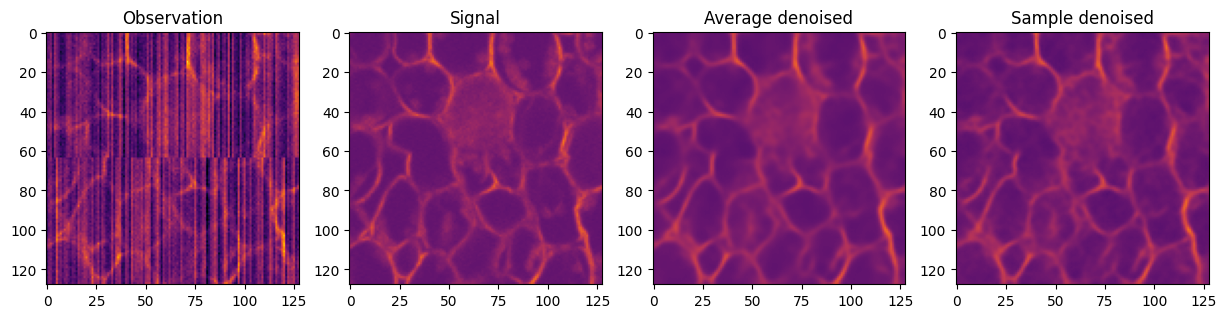

In [17]:
idx = np.random.randint(avg.shape[0])
sample_idx = np.random.randint(100)

vmin = np.percentile(observation, 0.1)
vmax = np.percentile(observation, 99.9)

plot(
    [observation[idx], signal[idx], avg[idx], samples[idx, sample_idx]],
    ["Observation", "Signal", "Average denoised", "Sample denoised"],
    vmin=vmin,
    vmax=vmax,
    cmap="inferno",
    figsize=(15, 15),
)

Compute PSNR

In [18]:
psnrs = []

for i in range(avg.shape[0]):
    range_psnr = np.max(signal[i]) - np.min(signal[i])
    psnrs.append(PSNR(signal[i], avg[i, 0], range_psnr))

print(np.mean(psnrs))

26.4392137496475


Save results

In [10]:
results_directory = '../results/conv'
if not os.path.exists(results_directory):
    os.makedirs(results_directory)
imsave(os.path.join(results_directory, 'avg.tif'), avg)
imsave(os.path.join(results_directory, 'samples.tif'), samples)